# Notebook 6: Interpreting Coefficients

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import glob
import pandas as pd
import sklearn
from src import corr_utils as corr_utils
from src import ana_utils as ana_utils
from src import vis_utils
import collections
import scipy.stats


#np.set_printoptions(suppress=True)
from sklearn import linear_model

np.random.seed(7)

In [2]:
wb_data = pd.read_csv("data/wb_data.csv", index_col="Country Name")
wb_data_short = pd.read_csv("data/wb_data_short.csv", index_col="Country Name")
whr_data = pd.read_csv("data/whr_data.csv", index_col="Country name")

To find out how important an indicator is for predicting the ladder score, we had the following idea:
First, we run a regression (ridge regression on the full dataset, since it had the best performance).
Second, we remove the indicator corresponding to the largest coefficient from the dataset.
Third, we re-run the regression on the reduced dataset. If removing the coefficient in step two leads to a decrease in performance, then that coefficient might be causally linked to the ladder score.

## Interpreting Coefficients for Ridge

#### Step 1: Ridge regression on full dataset

In [3]:
ridge = sklearn.linear_model.Ridge(alpha=0.25)

Mean loss (full set of indicators): 0.3270646691901955


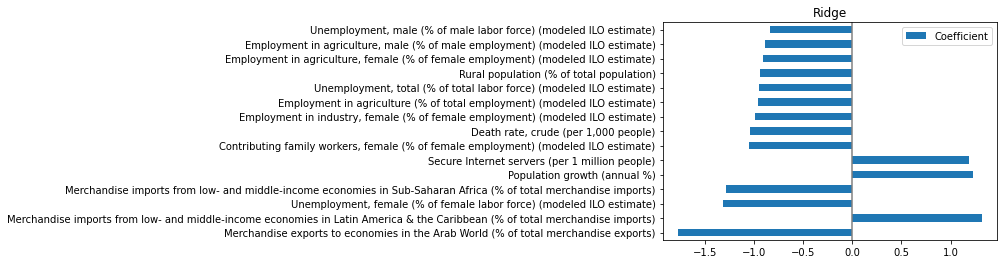

In [4]:
test_size = 30
loss_list, mean_loss, coef_list, avg_coefs = ana_utils.n_fold_ceval(reg_model=ridge, n=1000, data=wb_data, gt=whr_data, test_size=test_size, scaling="normalize")
print("Mean loss (full set of indicators):", mean_loss)
vis_utils.visualize_coefs(reg_model=ridge, indicators=wb_data.columns.values, n=15)

#### Step 2: Remove largest coefficient from dataset

In [5]:
largest_coef = ana_utils.get_largest_coefs(ridge, wb_data.columns.values, 1).index.values
print(largest_coef)
wb_data_red = wb_data.drop(largest_coef, axis=1)

['Merchandise exports to economies in the Arab World (% of total merchandise exports)']


#### Step 3: Re-run regression

Mean train loss (full set of indicators): 0.2223585710601102
Mean test loss (full set of indicators): 0.3526242998125985
R-Squared:  1.5938920136311108


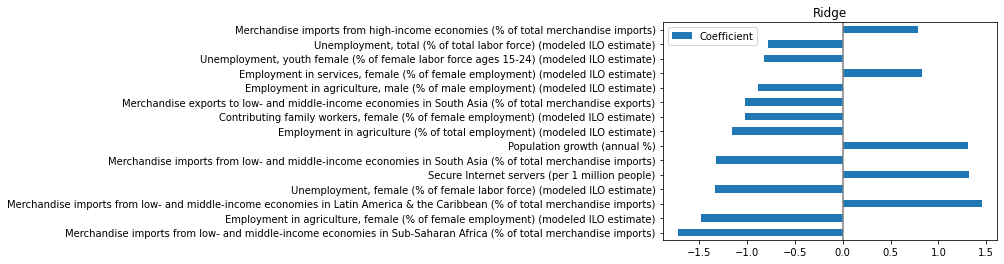

In [6]:
loss_list, mean_test_loss, mean_train_loss, coef_list, avg_coefs, r_sq = ana_utils.n_fold_ceval(reg_model=ridge, n=1000, data=wb_data_red, gt=whr_data, 
                                                                                          test_size=test_size, scaling="normalize", calc_adj_r_squared=True)
print("Mean train loss (full set of indicators):", mean_train_loss)
print("Mean test loss (full set of indicators):", mean_test_loss)
print("R-Squared: ", r_sq)
vis_utils.visualize_coefs(reg_model=ridge, indicators=wb_data_red.columns.values, n=15)

#### Step 4: Rinse and repeat

In [8]:
wb_data_red = wb_data.copy(deep=True)

for i in range(0, 31):
    _, ridge_mean_teloss, ridge_mean_trloss, _, _, ridge_adj_r_sq = ana_utils.n_fold_ceval(reg_model=ridge, n=1000, data=wb_data_red, gt=whr_data, 
                                                                        test_size=test_size, scaling="normalize", calc_adj_r_squared=True)
    largest_coef = ana_utils.get_largest_coefs(ridge, wb_data_red.columns.values, 1).index.values
    #print("Mean  train loss: ", ridge_mean_trloss)
    print(str(i), ". mean test loss: ", ridge_mean_teloss)
    #print("Adjusted R-Squared: ", ridge_adj_r_sq)
    print("Removing coefficient ", largest_coef, "\n")
    wb_data_red = wb_data_red.drop(largest_coef, axis=1)

0 . mean test loss:  0.32486321164709364
Removing coefficient  ['Merchandise exports to economies in the Arab World (% of total merchandise exports)'] 

1 . mean test loss:  0.35013212769186225
Removing coefficient  ['Merchandise imports from low- and middle-income economies in Sub-Saharan Africa (% of total merchandise imports)'] 

2 . mean test loss:  0.36992109113814287
Removing coefficient  ['Employment in agriculture, female (% of female employment) (modeled ILO estimate)'] 

3 . mean test loss:  0.3674593436498753
Removing coefficient  ['Merchandise imports from low- and middle-income economies in Latin America & the Caribbean (% of total merchandise imports)'] 

4 . mean test loss:  0.37952729244031075
Removing coefficient  ['Unemployment, female (% of female labor force) (modeled ILO estimate)'] 

5 . mean test loss:  0.38489514036684247
Removing coefficient  ['Rural population (% of total population)'] 

6 . mean test loss:  0.3889107007192474
Removing coefficient  ['Employmen

## Interpreting Coefficients for Lasso

In [9]:
lasso = sklearn.linear_model.Lasso(alpha=0.001, max_iter=10_000)

test_size=30
wb_data_red = wb_data.copy(deep=True)

for i in range(0, 31):
    _, lasso_mean_teloss, lasso_mean_trloss, _, _, lasso_adj_r_sq = ana_utils.n_fold_ceval(reg_model=lasso, n=1000, data=wb_data_red, gt=whr_data, 
                                                                        test_size=test_size, scaling="normalize", calc_adj_r_squared=True)
    largest_coef = ana_utils.get_largest_coefs(lasso, wb_data_red.columns.values, 1).index.values
    #print("Mean train loss: ", lasso_mean_trloss)
    print(str(i), ". mean tests loss: ", lasso_mean_teloss)
    #print("Adjusted R-Squared: ", lasso_adj_r_sq)
    print("Removing coefficient ", largest_coef, "\n")
    wb_data_red = wb_data_red.drop(largest_coef, axis=1)

0 . mean tests loss:  0.3763216591361008
Removing coefficient  ['Employment in agriculture (% of total employment) (modeled ILO estimate)'] 

1 . mean tests loss:  0.3781103636161305
Removing coefficient  ['Employment in agriculture, male (% of male employment) (modeled ILO estimate)'] 

2 . mean tests loss:  0.3798426060965119
Removing coefficient  ['Population ages 50-54, male (% of male population)'] 

3 . mean tests loss:  0.37425941442745037
Removing coefficient  ['Unemployment, female (% of female labor force) (modeled ILO estimate)'] 

4 . mean tests loss:  0.3769106467803877
Removing coefficient  ['Unemployment, total (% of total labor force) (modeled ILO estimate)'] 

5 . mean tests loss:  0.38924272195097
Removing coefficient  ['Age dependency ratio, young (% of working-age population)'] 

6 . mean tests loss:  0.3914952046546637
Removing coefficient  ['Death rate, crude (per 1,000 people)'] 

7 . mean tests loss:  0.3926350199517104
Removing coefficient  ['Access to electric

## Interpreting Coefficients for PLS

In [10]:
from sklearn.cross_decomposition import PLSRegression

In [11]:
pls = PLSRegression(n_components=4)

test_size=30
wb_data_red = wb_data.copy(deep=True)

for i in range(0, 31):
    _, pls_mean_teloss, pls_mean_trloss, _, _, pls_adj_r_sq = ana_utils.n_fold_ceval(reg_model=pls, n=1000, data=wb_data_red, gt=whr_data, 
                                                                        test_size=test_size, scaling="normalize", calc_adj_r_squared=True)
    largest_coef = ana_utils.get_largest_coef_pls(pls, wb_data_red.columns.values).index.values[0]
    #print("Mean train loss: ", pls_mean_trloss)
    print(str(i), ". mean tests loss: ", pls_mean_teloss)
    #print("Adjusted R-Squared: ", pls_adj_r_sq)
    print("Removing coefficient ", largest_coef, "\n")
    wb_data_red = wb_data_red.drop(largest_coef, axis=1)

0 . mean tests loss:  0.3575469756875508
Removing coefficient  Merchandise exports to economies in the Arab World (% of total merchandise exports) 

1 . mean tests loss:  0.38468604798086115
Removing coefficient  Merchandise imports from high-income economies (% of total merchandise imports) 

2 . mean tests loss:  0.3868590163964413
Removing coefficient  Merchandise imports from low- and middle-income economies in South Asia (% of total merchandise imports) 

3 . mean tests loss:  0.38476278667012803
Removing coefficient  Population density (people per sq. km of land area) 

4 . mean tests loss:  0.38557596057365656
Removing coefficient  Merchandise imports from low- and middle-income economies in Sub-Saharan Africa (% of total merchandise imports) 

5 . mean tests loss:  0.4031626739401164
Removing coefficient  Merchandise imports from low- and middle-income economies in Latin America & the Caribbean (% of total merchandise imports) 

6 . mean tests loss:  0.4098933694636452
Removing

## Interpreting Coefficients for Least Squares

In [4]:
from sklearn.linear_model import LinearRegression
least_squares = sklearn.linear_model.LinearRegression()

corr_utils.coef_removal_sim(15, 50, least_squares, 20, wb_data, whr_data)

0.5481243979837814
0.5716631310455932
0.7023615045632188
